<a href="https://colab.research.google.com/github/Shekhawat34/Machine-Learning-Project/blob/main/Lumbar_Coordinated_detection_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project: Lumbar Coordinate Detection/Matching

The dataset consists of various medical images of the lower lumbar spine (external data). Each image is given 5 key points that correspond to the 5 lower lumbar vertebrae. https://www.kaggle.com/datasets/brendanartley/lumbar-coordinate-pretraining-dataset

In [1]:

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d brendanartley/lumbar-coordinate-pretraining-dataset

import zipfile
zip_ref = zipfile.ZipFile('lumbar-coordinate-pretraining-dataset.zip', 'r')
zip_ref.extractall('/content/Lumbar_Coordinate_pretraining_dataset')
zip_ref.close()


Dataset URL: https://www.kaggle.com/datasets/brendanartley/lumbar-coordinate-pretraining-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 707M/717M [00:07<00:00, 114MB/s]
100% 717M/717M [00:07<00:00, 102MB/s]


## Load the Folders inside the Main Directory

In [3]:
import os

def get_folders(directory):
  """Lists only folders within a given directory."""
  folders = []
  for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
      folders.append(item)
  return folders

folders = get_folders('/content/Lumbar_Coordinate_pretraining_dataset/data')
print(folders)


['processed_osf', 'processed_spider', 'processed_tseg_jpgs', 'processed_osf_jpgs', 'processed_tseg', 'processed_lsd', 'processed_spider_jpgs', 'processed_lsd_jpgs']


In [4]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
!pip install timm
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.6 MB/s eta 0:00:00


In [7]:
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 26.1 MB/s eta 0:00:00


## Import all the libraries requires

In [8]:
import os
import glob
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from types import SimpleNamespace
import albumentations as A
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import pydicom

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [9]:
cfg= SimpleNamespace(
    img_dir= "/content/Lumbar_Coordinate_pretraining_dataset/data",
    device= torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    n_frames=3,
    epochs=10,
    lr=0.0005,
    batch_size=16,
    backbone="resnet18",
    seed= 0,
)
set_seed(seed=cfg.seed)

## Load the coordinated file

In [10]:
# Load metadata
df= pd.read_csv("/content/Lumbar_Coordinate_pretraining_dataset/coords_pretrain.csv")
df= df.sort_values(["source", "filename", "level"]).reset_index(drop=True)
df["filename"] = df["filename"].str.replace(".jpg", ".npy")
df["series_id"] = df["source"] + "_" + df["filename"].str.split(".").str[0]

print("----- IMGS per source -----")
display((df.source.value_counts()/5).astype(int).reset_index())

----- IMGS per source -----


,source,count
0,lsd,504
1,tseg,375
2,spider,209
3,osf,33


## Pretraining

In [11]:
class PreTrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, cfg):
        self.cfg= cfg
        self.records= self.load_coords(df)

    def load_coords(self, df):
        # Convert to dict
        d = df.groupby("series_id")[["relative_x", "relative_y"]].apply(lambda x: list(x.itertuples(index=False, name=None)))
        records= {}
        for i, (k,v) in enumerate(d.items()):
            records[i]= {"series_id": k, "label": np.array(v).flatten()}
            assert len(v) == 5

        return records

    def pad_image(self, img):
        n= img.shape[-1]
        if n >= self.cfg.n_frames:
            start_idx = (n - self.cfg.n_frames) // 2
            return img[:, :, start_idx:start_idx + self.cfg.n_frames]
        else:
            pad_left = (self.cfg.n_frames - n) // 2
            pad_right = self.cfg.n_frames - n - pad_left
            return np.pad(img, ((0,0), (0,0), (pad_left, pad_right)), 'constant', constant_values=0)

    def load_img(self, source, series_id):
        fname= os.path.join(self.cfg.img_dir, "processed_{}/{}.npy".format(source, series_id))
        img= np.load(fname).astype(np.float32)
        img= self.pad_image(img)
        img= np.transpose(img, (2, 0, 1))
        img= (img / 255.0)
        return img


    def __getitem__(self, idx):
        d= self.records[idx]
        label= d["label"]
        source= d["series_id"].split("_")[0]
        series_id= "_".join(d["series_id"].split("_")[1:])

        img= self.load_img(source, series_id)
        return {
            'img': img,
            'label': label,
            }

    def __len__(self,):
        return len(self.records)

ds= PreTrainDataset(df, cfg)


print("---- Sample Shapes -----")
for k, v in ds[0].items():
    print(k, v.shape)

---- Sample Shapes -----
img (3, 256, 256)
label (10,)


## Batch to use multiple images for lumbar coordinetes matching

In [12]:
def batch_to_device(batch, device, skip_keys=[]):
    batch_dict= {}
    for key in batch:
        if key in skip_keys:
             batch_dict[key]= batch[key]
        else:
            batch_dict[key]= batch[key].to(device)
    return batch_dict

def visualize_prediction(batch, pred, epoch):

    mid= cfg.n_frames//2

    # Plot
    for idx in range(1):

        # Select Data
        img= batch["img"][idx, mid, :, :].cpu().numpy()*255
        cs_true= batch["label"][idx, ...].cpu().numpy()*256
        cs= pred[idx, ...].cpu().numpy()*256

        coords_list = [("TRUE", "lightblue", cs_true), ("PRED", "orange", cs)]
        text_labels = [str(x) for x in range(1,6)]

        # Plot coords
        fig, axes = plt.subplots(1, len(coords_list), figsize=(10,4))
        fig.suptitle("EPOCH: {}".format(epoch))
        for ax, (title, color, coords) in zip(axes, coords_list):
            ax.imshow(img, cmap='gray')
            ax.scatter(coords[0::2], coords[1::2], c=color, s=50)
            ax.axis('off')
            ax.set_title(title)

            # Add text labels near the coordinates
            for i, (x, y) in enumerate(zip(coords[0::2], coords[1::2])):
                if i < len(text_labels):  # Ensure there are enough labels
                    ax.text(x + 10, y, text_labels[i], color='white', fontsize=15, bbox=dict(facecolor='black', alpha=0.5))


        fig.suptitle("EPOCH: {}".format(epoch))
        plt.show()
#         plt.close(fig)
    return

def load_weights_skip_mismatch(model, weights_path, device):
    # Load Weights
    state_dict = torch.load(weights_path, map_location=device)
    model_dict = model.state_dict()

    # Iter models
    params = {}
    for (sdk, sfv), (mdk, mdv) in zip(state_dict.items(), model_dict.items()):
        if sfv.size() == mdv.size():
            params[sdk] = sfv
        else:
            print("Skipping param: {}, {} != {}".format(sdk, sfv.size(), mdv.size()))

    # Reload + Skip
    model.load_state_dict(params, strict=False)
    print("Loaded weights from:", weights_path)

## Train and Validate the dataset

In [13]:
train_df= df[df["source"] != "spider"]
val_df= df[df["source"] == "spider"]
print("TRAIN_SIZE: {}, VAL_SIZE: {}".format(len(train_df)//5, len(val_df)//5))

# Datasets + Dataloaders
train_ds= PreTrainDataset(train_df, cfg)
val_ds= PreTrainDataset(val_df, cfg)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)

# Model
model = timm.create_model('resnet18', pretrained=True, num_classes=10)
model = model.to(cfg.device)

# Loss / Optim
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

TRAIN_SIZE: 912, VAL_SIZE: 209


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

## Evaluate the model

100%|██████████| 14/14 [00:02<00:00,  6.70it/s]


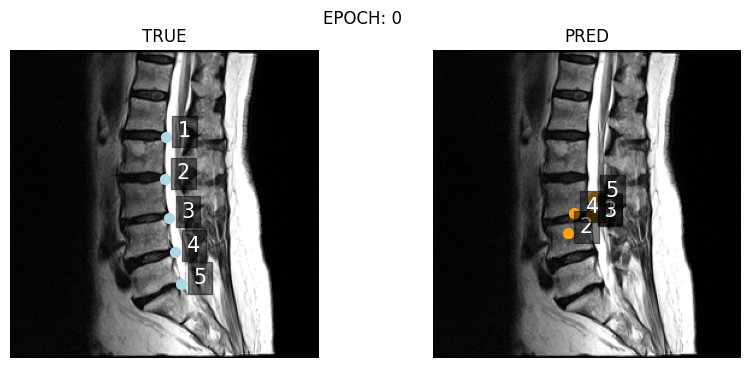

Epoch 1, Training Loss: 0.0, Validation Loss: 0.02208871886666332


100%|██████████| 14/14 [00:01<00:00,  9.15it/s]


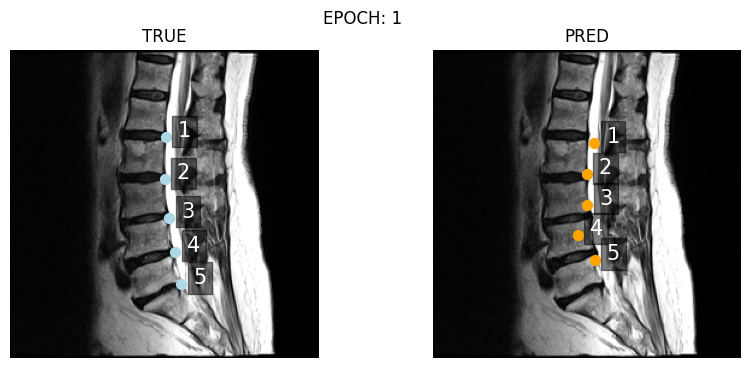

Epoch 2, Training Loss: 0.0007598353549838066, Validation Loss: 0.0038246294550065485


100%|██████████| 14/14 [00:01<00:00,  9.50it/s]


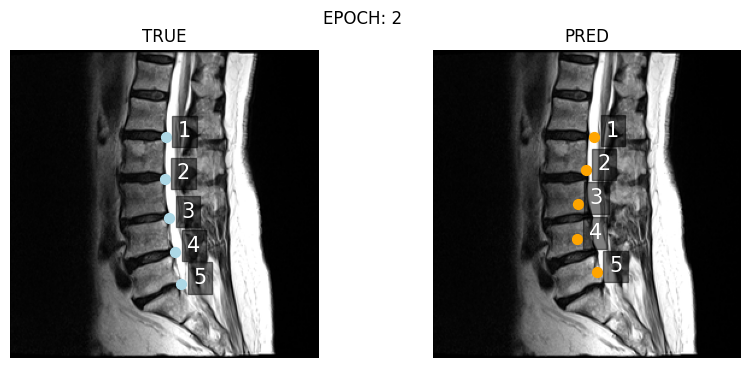

Epoch 3, Training Loss: 0.001179755898192525, Validation Loss: 0.003317925363912114


100%|██████████| 14/14 [00:01<00:00,  7.49it/s]


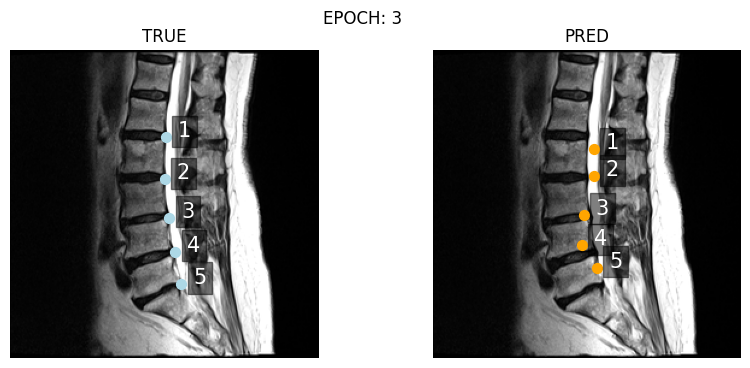

Epoch 4, Training Loss: 0.0005686803488060832, Validation Loss: 0.0029246962720727815


100%|██████████| 14/14 [00:01<00:00,  9.23it/s]


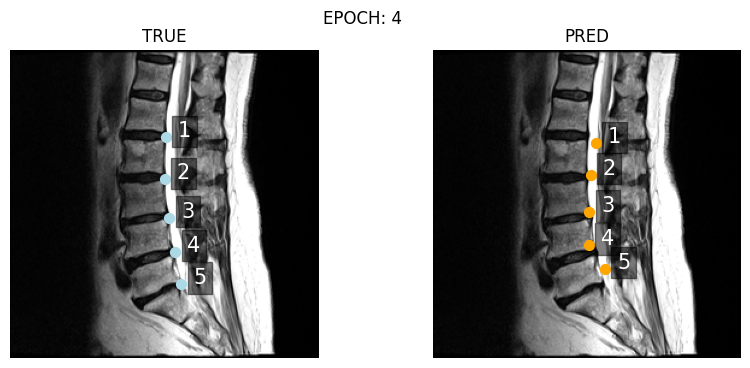

Epoch 5, Training Loss: 0.00027561839669942856, Validation Loss: 0.0026152563056842026


100%|██████████| 14/14 [00:01<00:00,  8.50it/s]


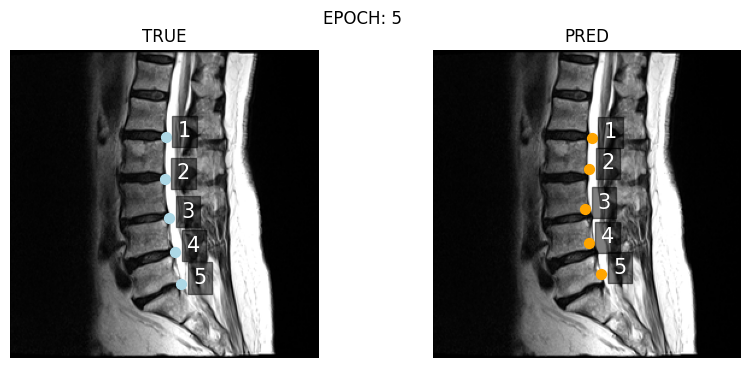

Epoch 6, Training Loss: 0.0002836388594005257, Validation Loss: 0.002410287353476243


100%|██████████| 14/14 [00:01<00:00,  7.50it/s]


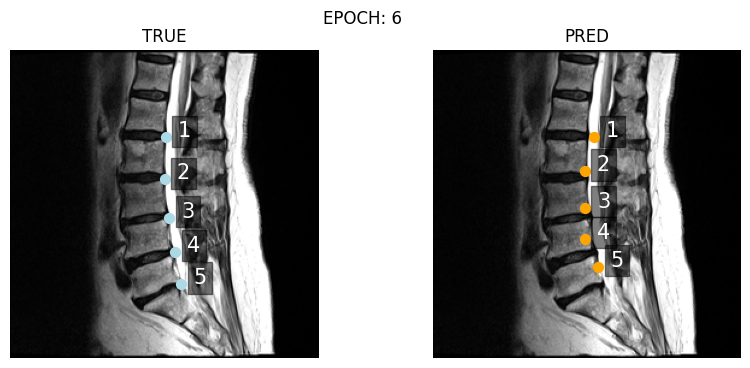

Epoch 7, Training Loss: 0.00029979689861647785, Validation Loss: 0.002585124848077872


100%|██████████| 14/14 [00:01<00:00,  8.10it/s]


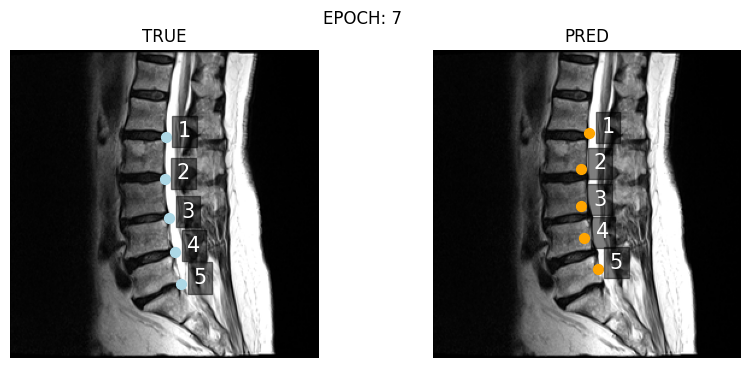

Epoch 8, Training Loss: 0.0003545244690030813, Validation Loss: 0.003116031376911061


100%|██████████| 14/14 [00:01<00:00,  7.64it/s]


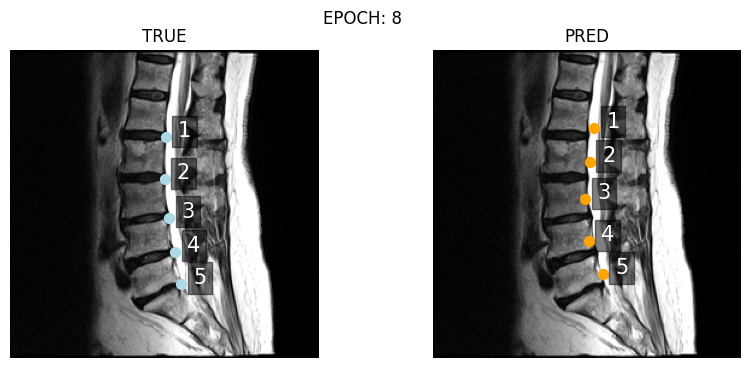

Epoch 9, Training Loss: 0.0005700847832486033, Validation Loss: 0.0023971396564905134


100%|██████████| 14/14 [00:01<00:00,  7.68it/s]


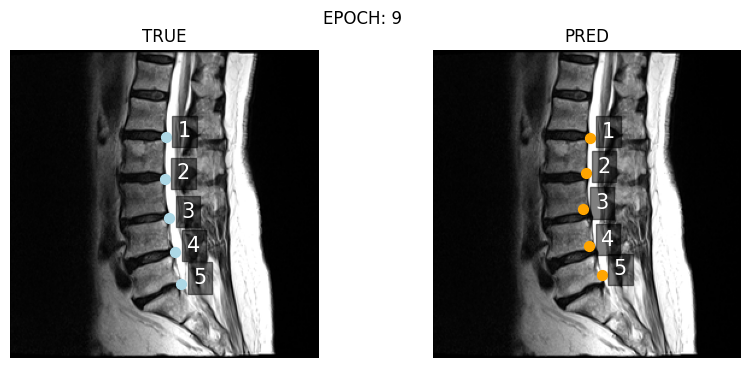

Epoch 10, Training Loss: 0.00019141552911605686, Validation Loss: 0.002662386237976274


100%|██████████| 14/14 [00:01<00:00,  7.92it/s]


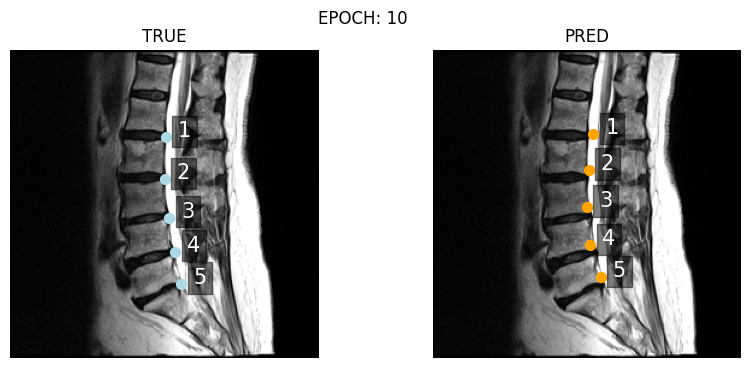

Epoch 11, Training Loss: 0.0001210257614729926, Validation Loss: 0.0024930821278498377
Training complete...


In [14]:
for epoch in range(cfg.epochs+1):

    # Train Loop
    loss= torch.tensor([0.]).float().to(cfg.device)
    if epoch != 0:
        model= model.train()
        for batch in tqdm(train_dl):
            batch = batch_to_device(batch, cfg.device)
            optimizer.zero_grad()

            x_out = model(batch["img"].float())
            x_out = torch.sigmoid(x_out)

            loss = criterion(x_out, batch["label"].float())
            loss.backward()
            optimizer.step()

    # Validation Loop
    val_loss = 0
    with torch.no_grad():
        model = model.eval()
        for batch in tqdm(val_dl):
            batch = batch_to_device(batch, cfg.device)

            pred = model(batch["img"].float())
            pred = torch.sigmoid(pred)

            val_loss += criterion(pred, batch["label"].float()).item()
        val_loss /= len(val_dl)

    # Viz
    visualize_prediction(batch, pred, epoch)

    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")
print("Training complete...")

#Save the model

In [15]:
f= "{}_{}.pt".format(cfg.backbone, cfg.seed)
torch.save(model.state_dict(), f)
print("Saved weights: {}".format(f))

Saved weights: resnet18_0.pt


In [16]:
model = timm.create_model('resnet18', pretrained=True, num_classes=75)
model = model.to(cfg.device)
load_weights_skip_mismatch(model, f, cfg.device)

Skipping param: fc.weight, torch.Size([10, 512]) != torch.Size([75, 512])
Skipping param: fc.bias, torch.Size([10]) != torch.Size([75])
Loaded weights from: resnet18_0.pt


<ipython-input-12-c89374a485b6>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)
